In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [2]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = ["naive",
                     #"weighted-naive"
                     ]

In [21]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] + pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [22]:
all_portfolio_returns = []
for method in portfolio_methods:

    dirs = os.listdir(os.path.join(outputs_path, method))

    for dir in dirs:
        print(dir)

        results = load_pickle(os.path.join(outputs_path, method, dir))
        
        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

results_mx_4.pkl
results_ls_2.pkl
results_mx_3.pkl
results_ls_4.pkl
results_mx_2.pkl
results_ls_3.pkl
results_lo_2.pkl
results_lo_3_rand.pkl
results_lo_3.pkl
results_ls_3_rand.pkl
results_lo_4.pkl


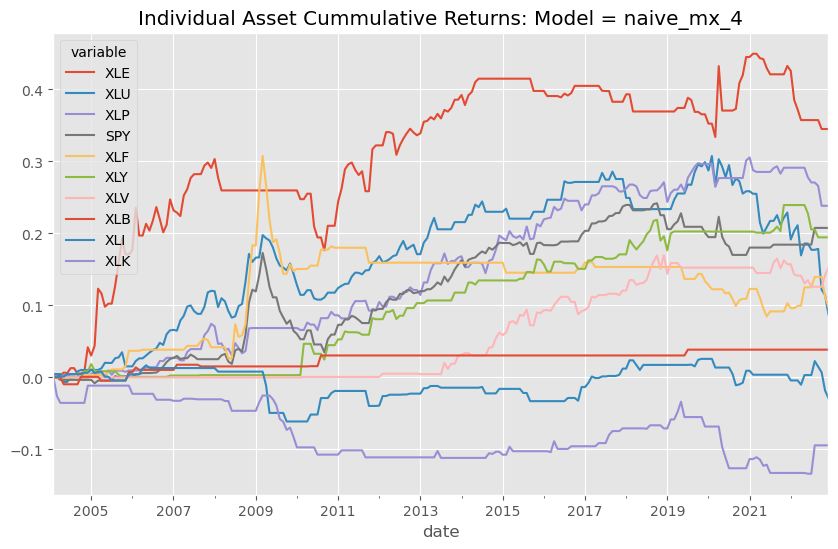

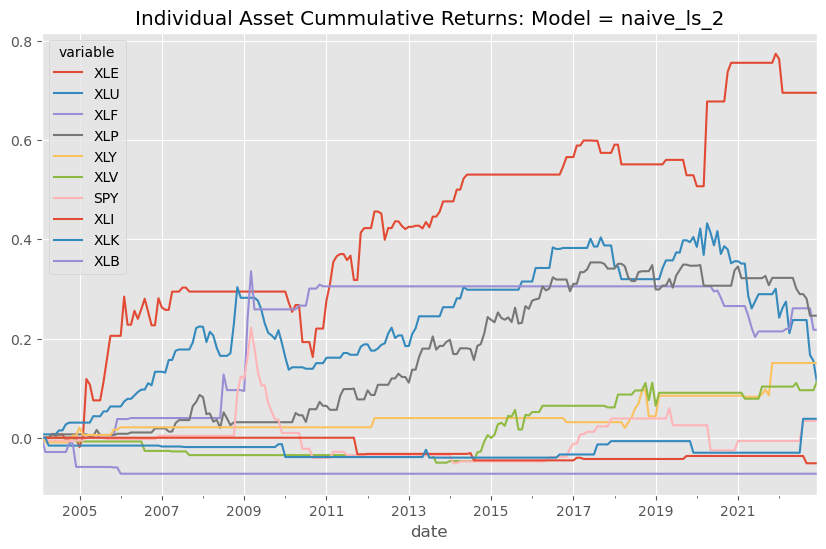

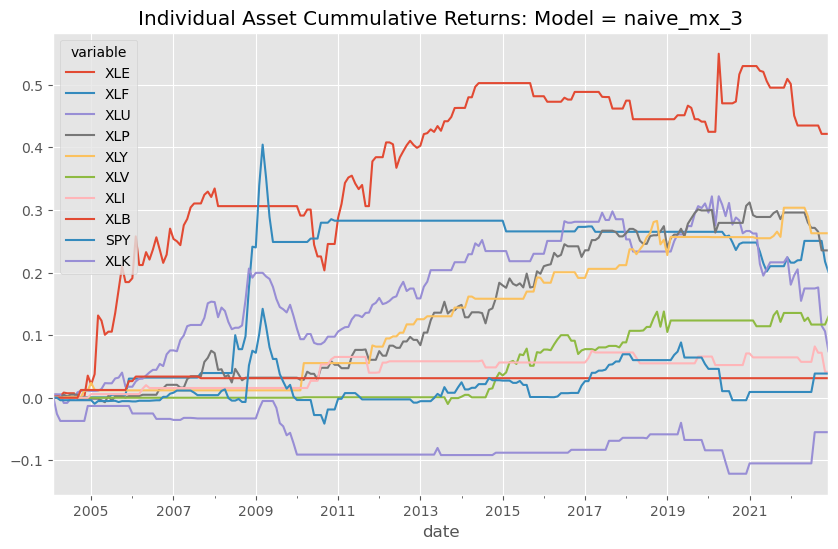

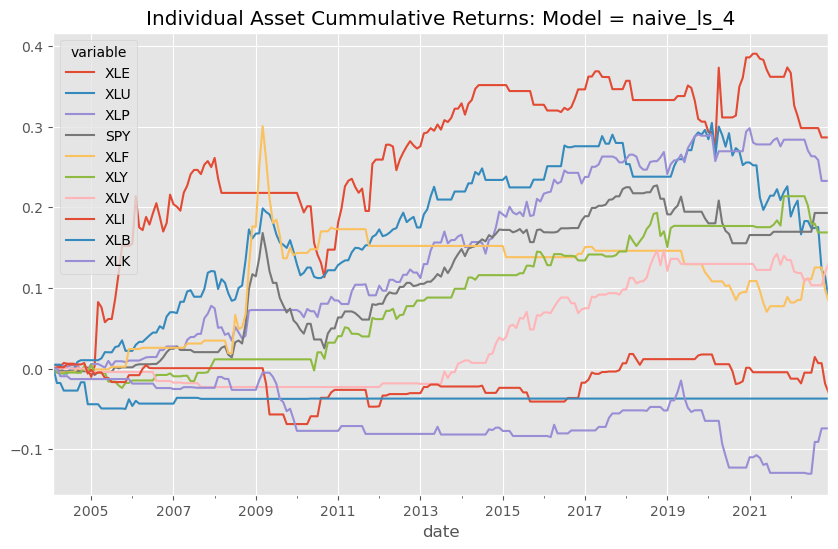

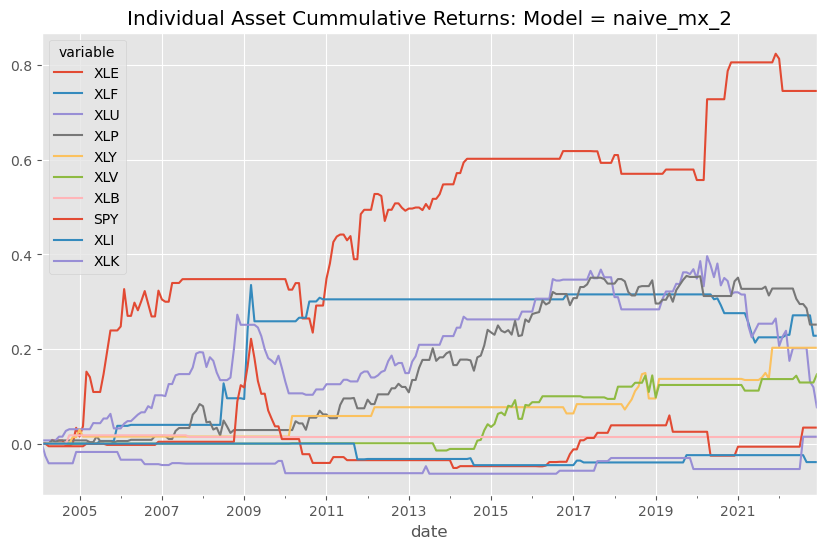

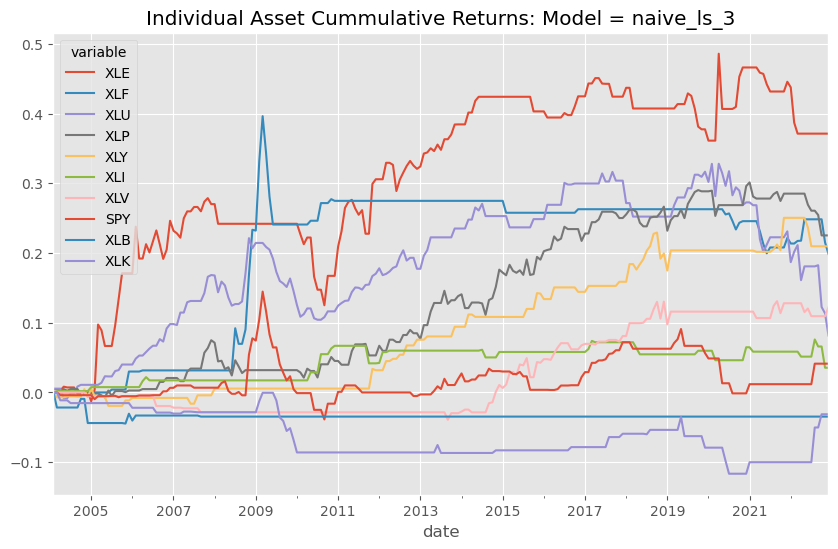

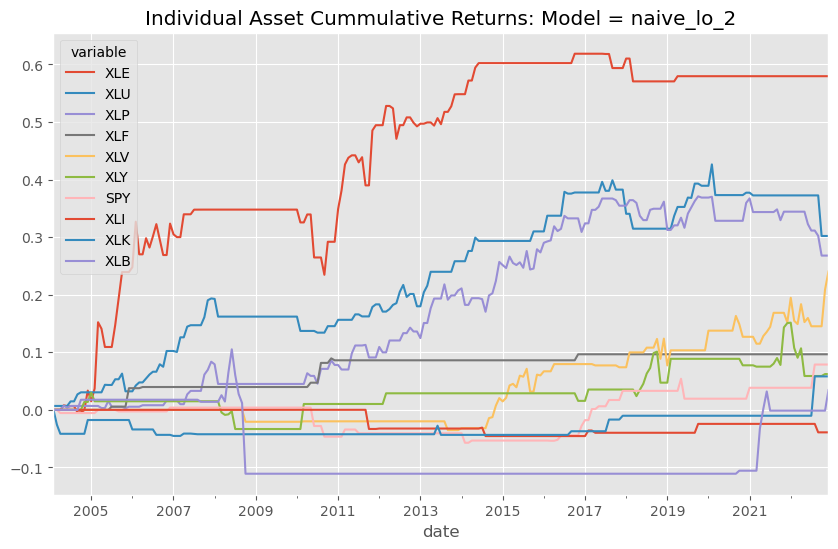

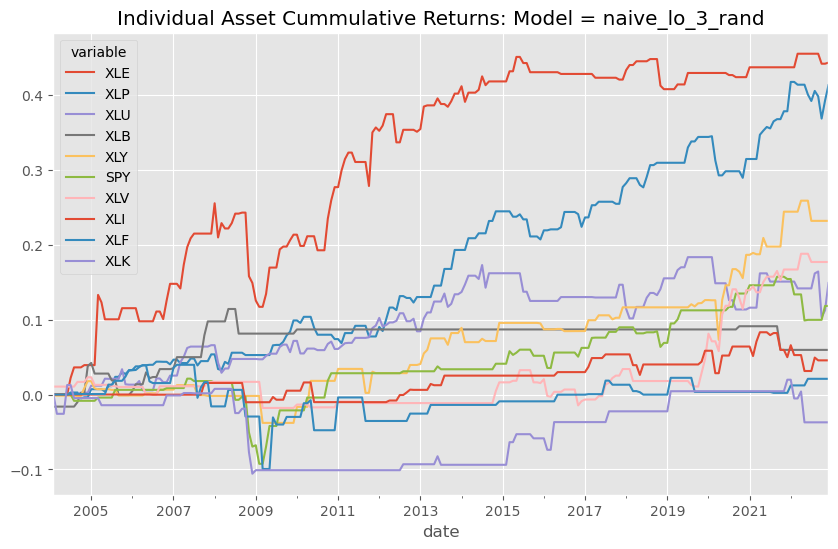

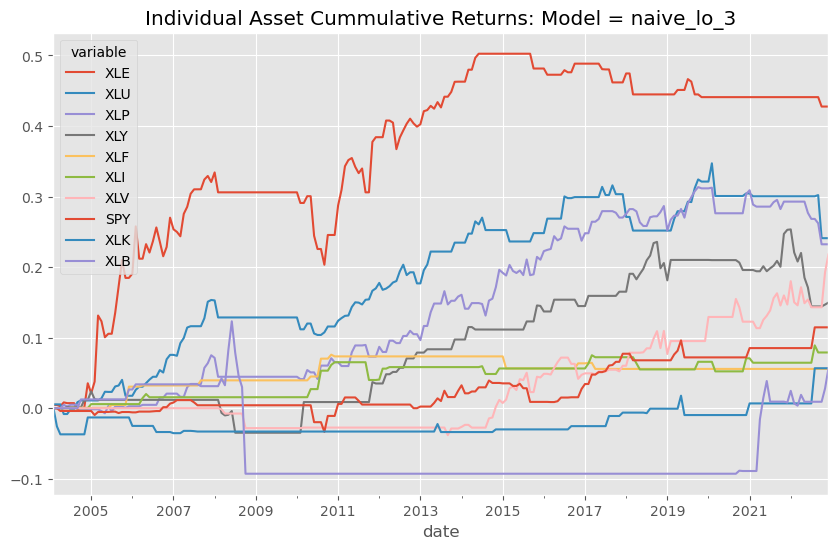

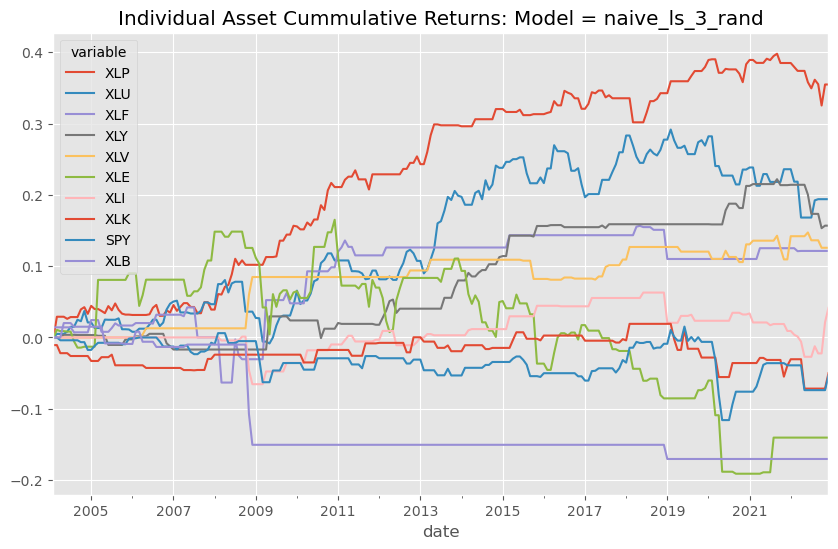

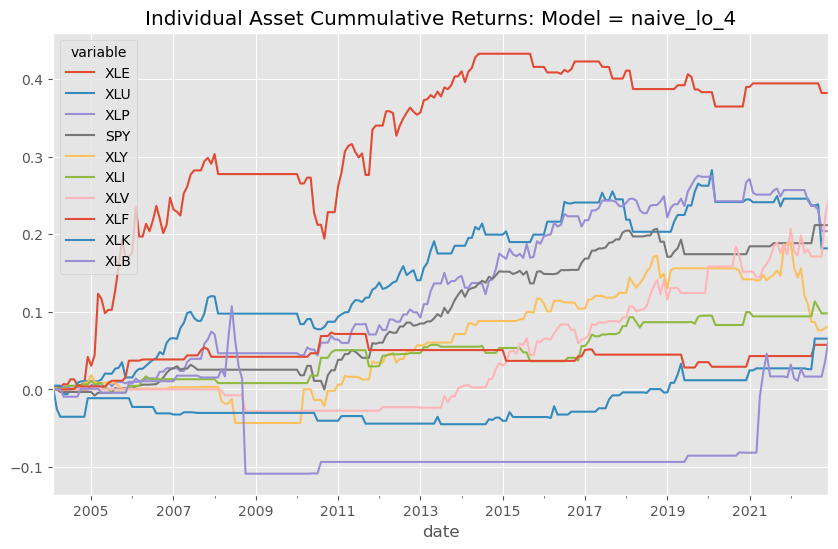

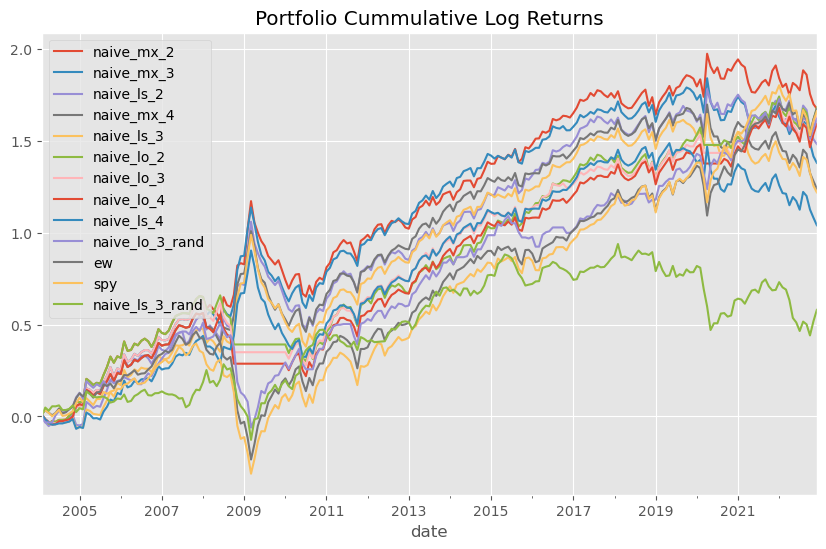

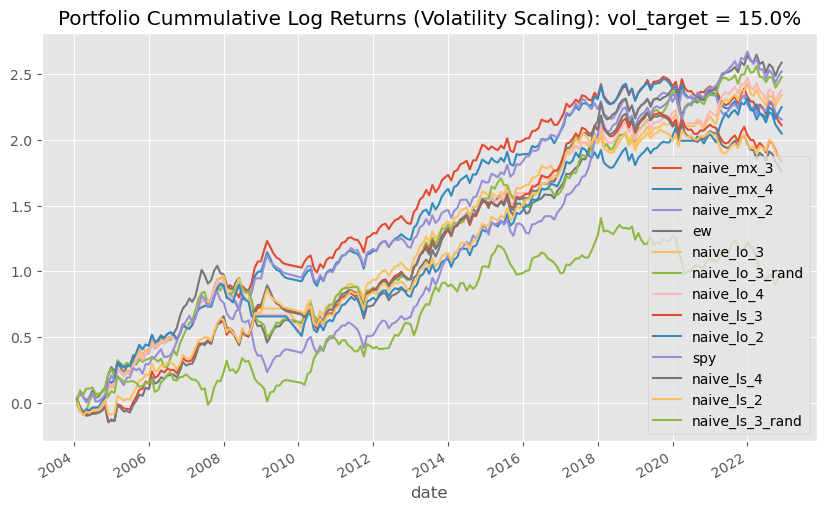

In [23]:
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
concat_list = [equal_weight_cumm_returns, spy_cumm_returns]

for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cummulative Returns: Model = {model}")
    plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))
cumm_returns_plot = pd.concat(concat_list, axis=1)
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), title=f"Portfolio Cummulative Log Returns")
plt.show()

# volatility scaling
vol_target = 0.15
portfolio_vol = vol_target / (cumm_returns_plot.rolling(window=12).std().bfill() * np.sqrt(12))
cumm_returns_plot = (cumm_returns_plot * portfolio_vol).dropna()
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), title=f"Portfolio Cummulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%")
plt.show()

In [13]:
all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
naive_ls_3,2.301858,14.218474,0.560811,0.900324,-3.896470,-15.418094,0.555556
naive_lo_3,4.951100,12.923288,1.327148,3.240056,-0.578574,-4.000623,0.617778
